# IMPORTS

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

## LEITURA DOS DADOS

In [76]:
df = pd.read_csv('../RawData/train_radiomics_hipocamp.csv') 
df_test = pd.read_csv('../RawData/test_radiomics_hipocamp.csv')

# Tratamento

### Single Value Colums 

In [77]:
df = df.loc[:, df.nunique() > 1]
df_test = df_test.loc[:, df_test.nunique() > 1]


#  Analise das colunas que tem menos de 50 valores unicos 
n = df.nunique()
for col, e in n.items():
    if e < 50:  
        print(f"Coluna: {col}, Valores Unicos : {e}")

Coluna: original_firstorder_10Percentile, Valores Unicos : 31
Coluna: original_firstorder_90Percentile, Valores Unicos : 13
Coluna: original_firstorder_InterquartileRange, Valores Unicos : 13
Coluna: original_firstorder_Maximum, Valores Unicos : 29
Coluna: original_firstorder_Median, Valores Unicos : 15
Coluna: original_firstorder_Minimum, Valores Unicos : 30
Coluna: original_firstorder_Range, Valores Unicos : 45
Coluna: wavelet-HHH_glszm_GrayLevelNonUniformityNormalized, Valores Unicos : 33
Coluna: wavelet-HHH_glszm_GrayLevelVariance, Valores Unicos : 34
Coluna: gradient_firstorder_Minimum, Valores Unicos : 3
Coluna: lbp-2D_firstorder_10Percentile, Valores Unicos : 4
Coluna: lbp-2D_firstorder_90Percentile, Valores Unicos : 2
Coluna: lbp-2D_firstorder_InterquartileRange, Valores Unicos : 3
Coluna: lbp-2D_firstorder_Median, Valores Unicos : 2
Coluna: lbp-3D-m1_firstorder_10Percentile, Valores Unicos : 10
Coluna: lbp-3D-m1_firstorder_90Percentile, Valores Unicos : 12
Coluna: lbp-3D-m1_fi

### AGE BINING  ( secalhar isto era no 2 )

In [78]:

age_bins = [0, 65, 75, 85, 100]
# BINS_SIZER = ['<65', '65-74', '75-84', '85+']
age_labels = [60, 70, 80, 90] # VALOR MEDIO DO BIN 
df['Age'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels).astype(int)
df_test['Age'] = pd.cut(df_test['Age'], bins=age_bins, labels=age_labels).astype(int)

print(df['Age'])

0      80
1      80
2      80
3      80
4      80
       ..
300    70
301    70
302    80
303    60
304    70
Name: Age, Length: 305, dtype: int64


### Colunas Categoricas 

In [79]:
# Analisar a contagem de valores únicos para cada coluna categórica

# Identificar as colunas categóricas
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    print(f"\nColuna: {col}")

#colunas_catagoricas_a_remover = ['ID', 'Image', 'Mask', 'diagnostics_Image-original_Hash', 'diagnostics_Mask-original_Hash'] 

colunas_catagoricas_a_remover = ['ID', 'Image', 'Mask', 'diagnostics_Image-original_Hash', 'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass'] 

# ** Bounding Box
#
# ** as colunas do 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass'
# ** Deveriam ser retiradas, mas o bounding box pode ser importante para a zona de maior ativação do Alzimeir 
# **  ja a de centro de maxima devem ser muito correlacionados, por isso devem ser retirados mais para a frente 
# *TODO acabei por retirar para correr melhor os modelos, mas analisar se se deve retirar ou nao 

df.drop(columns=colunas_catagoricas_a_remover,axis= 1 , inplace= True)
df_test.drop(columns=colunas_catagoricas_a_remover,axis= 1 , inplace= True)


Coluna: ID

Coluna: Image

Coluna: Mask

Coluna: diagnostics_Image-original_Hash

Coluna: diagnostics_Mask-original_Hash

Coluna: diagnostics_Mask-original_BoundingBox

Coluna: diagnostics_Mask-original_CenterOfMassIndex

Coluna: diagnostics_Mask-original_CenterOfMass

Coluna: Transition


### Eliminar Transition CN-MCI 

Como este tipo de precisao não vai ser realiza, decidimos retirar todas as linhas com ela relacinadas para nao confundir o nosso modelo

In [80]:
df = df[df['Transition'] != 'CN-MCI']

### Label Encoding

In [81]:
label_mapping = {
    'CN-CN': 0,
    'AD-AD': 1,
    'MCI-AD': 2,
    'MCI-MCI': 3,
#    'CN-MCI' : 4
}
# Apply the mapping to the target column
df['Transition'] = df['Transition'].map(label_mapping)

## Models

In [82]:

#experiment = setup(df, target='Transition')

In [83]:
#best = compare_models()

Com o tratamento atual, o pycaret diz que os melhores modelos são :
- Random Forest Classifier
- Extra Trees Classifier
- Gradient Boosting Classifier 
- K Neighbors Classifier
- Extreme Gradient Boosting 


### Aplicação dos modelos (default) ao dataset tratado

In [84]:
from imblearn.over_sampling import SMOTE


In [85]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Separar as features e o target
X = df.drop('Transition', axis=1)
y = df['Transition']

# Exibir as primeiras linhas e a forma de X
print("X:")
print(X.head())
print("X Shape:", X.shape)

# Dividir o conjunto de dados em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=34, stratify=y)





# Normalizar os dados usando StandardScaler
scaler = StandardScaler()

# Ajustar o scaler apenas nos dados de treino e transformar os dados de treino e teste
X_res = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Exibir formas e primeiras linhas dos dados normalizados


# Exibir a contagem de amostras por classe após o SMOTE
print("Y Smote Values:")
print(y_test.value_counts())

# Inicializar dicionário para armazenar as pontuações de cross-validation do modelo
model_cross_score = {}


X:
   diagnostics_Image-original_Mean  diagnostics_Image-original_Maximum  \
0                         5.848123                                 178   
1                         5.238834                                 190   
2                         6.816667                                 155   
4                         5.568269                                 150   
5                         5.359231                                 157   

   diagnostics_Mask-original_VoxelNum  original_shape_Elongation  \
0                                7106                   0.420040   
1                                7779                   0.425482   
2                                6707                   0.447685   
4                                5986                   0.411851   
5                                5895                   0.421088   

   original_shape_Flatness  original_shape_LeastAxisLength  \
0                 0.106547                       10.757474   
1                 0

In [86]:
print("X res Values:")
#X_res.value_counts()

print("Y Res Values:")
#y_res.value_counts()


X res Values:
Y Res Values:


### SMOTE

In [87]:
def plot_confusion_matrix_with_labels(confusion_matrix, label_mapping):
    # Criar um mapeamento inverso
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}
    
    # Aplicar o mapeamento inverso na matriz de confusão
    cm_with_labels = np.zeros_like(confusion_matrix, dtype=object)
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            cm_with_labels[i, j] = f"{reverse_label_mapping[i]} (Pred: {reverse_label_mapping[j]})"

    # Criar um DataFrame para facilitar a visualização
    df_cm = pd.DataFrame(confusion_matrix, index=reverse_label_mapping.values(), columns=reverse_label_mapping.values())
    
    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix with Labels')
    plt.show()

#### Random Forest Classifier

In [88]:

rf_model = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=34)

rf_score = cross_val_score(rf_model, X_res, y_train, cv=5,scoring='f1_macro').mean()

model_cross_score['random_forest'] = rf_score





#### Extra Trees Classifier

In [89]:
et_model = ExtraTreesClassifier(criterion='gini', max_depth=20, random_state=34)

model_cross_score['Extra Trees'] = cross_val_score(et_model, X_res, y_train, cv=5,scoring='f1_macro').mean()

print(model_cross_score['Extra Trees'])

0.4032901692386238


#### Gradient Boosting Classifier 

In [90]:
gb_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=34)

score_cross = cross_val_score(gb_model,X_res,y_train,cv=5,scoring='f1_macro').mean()

print(score_cross)

model_cross_score['Gradient_boosting'] = score_cross



0.3878309574020302


#### K Neighbors Classifier

In [91]:
kn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')

k_night_croos_score = cross_val_score(kn_model, X_res, y_train, cv=10,scoring='f1_macro')

print("Acuracy k night", k_night_croos_score.mean())


model_cross_score['k_night'] = k_night_croos_score.mean()




Acuracy k night 0.42985670203549464


#### Extreme Gradient Boosting

In [92]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05,colsample_bytree=0.4, subsample=0.8, random_state=34)


score_cross = cross_val_score(xgb_model,X_res,y_train,cv=5,scoring='f1_macro').mean()

print(score_cross)

model_cross_score['XGBoost'] = score_cross



0.4007835907642409


SVC

In [93]:
from sklearn.svm import SVC


svc_moldel = SVC(kernel='rbf', random_state=34)


score_cross = cross_val_score(xgb_model,X_res,y_train,cv=5,scoring='f1_macro').mean()

print(score_cross)

model_cross_score['SVC'] = score_cross



0.4007835907642409


In [94]:
print("Numero de Colunas")
print(X_train.shape)
print("Numero de Colunas com Smote")
print(X_res.shape)

# função que compara os modelos, para isso, usa um dicionário {"Model Name: [predictions], ..."}
def compare_models(Y_test, predictions):
    # Create a dictionary of models and their respective accuracies
    model_accuracies = {}
    for name, prediction in predictions.items():
        # Calculate the accuracy for each model
        accuracy = sum(prediction == Y_test) / len(Y_test)
        # Add the model and its accuracy to the dictionary
        model_accuracies[name] = accuracy

    # Sort the models by their accuracy in ascending order
    sorted_models = sorted(model_accuracies, key=model_accuracies.get)

    # Print the table with the accuracy of each model
    print("Model".ljust(20), "Accuracy")
    print("-" * 30)
    for model in sorted_models:
        print(model.ljust(20), str(model_accuracies[model]).rjust(10))


#predictions = {
#    'Random Forest Classifier' : rf_pred,
#    'Extra Trees Classifier' : et_pred,
#    'Gradient Boosting Classifier' : gb_pred,
#    'K Neighbors Classifier' : kn_pred,
#    'Extreme Gradient Boosting' : xgb_pred
#    
#}

#compare_models(y_test, predictions)


def compare_models_cross_score(model_cross_score):
    # Sort models by cross-validation score in descending order
    sorted_models = sorted(model_cross_score.items(), key=lambda x: x[1], reverse=True)

    # Print the table with the cross-validation score of each model
    print("Model".ljust(30), "Cross-Validation Score")
    print("-" * 45)
    for model, score in sorted_models:
        print(model.ljust(30), f"{score:.4f}".rjust(10))



compare_models_cross_score(model_cross_score)


Numero de Colunas
(221, 2013)
Numero de Colunas com Smote
(221, 2013)
Model                          Cross-Validation Score
---------------------------------------------
k_night                            0.4299
random_forest                      0.4165
Extra Trees                        0.4033
XGBoost                            0.4008
SVC                                0.4008
Gradient_boosting                  0.3878


K means 

InvalidIndexError: (slice(None, None, None), 0)

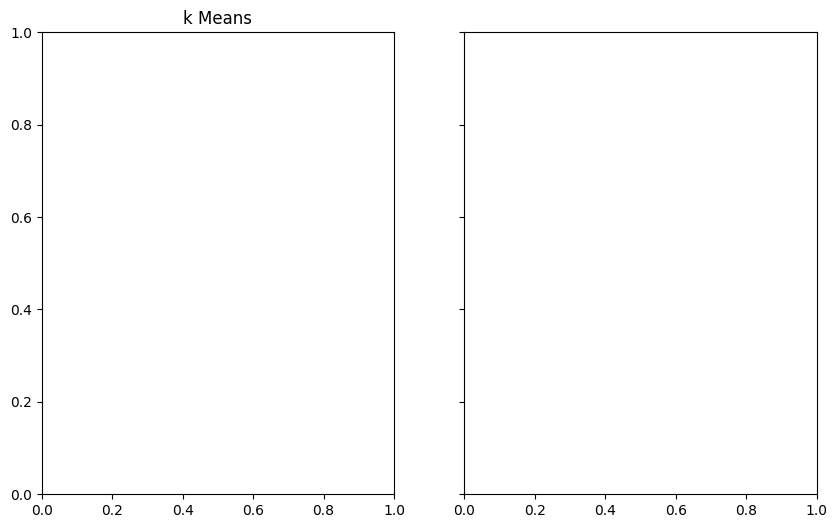

In [96]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=4,n_init='auto',random_state=34)
kmeans.fit(X_train)

f, (ax1,ax2) = plt.subplots(1,2,sharey=True, figsize = (10,6))

ax1.set_title('k Means')
ax1.scatter(X_train[:,0], X_train[:,1], c = kmeans.labels_, cmap = 'rainbow')
ax2.set_title('Original')
ax2.scatter(X_test[:,0], X_test[:,1], c = y_test, cmap = 'rainbow')

for i, txt in enumerate(y_test): 
    if i%5==0: 
        plt.annotate(txt,(X_train[i,0], X_train[i,1]))



